In [1]:
from dataclasses import dataclass
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt
from scipy.optimize import minimize, OptimizeResult


@dataclass
class OptimizationResult:
    result: OptimizeResult
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]

    def plot(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()


@dataclass
class SimulationResult:
    dimension: int
    times: npt.NDArray[np.float64]
    unitaries: list[qt.Qobj]
    states: list[qt.Qobj]
    infidelities: list[float]

    def substates(self, index) -> list[qt.Qobj]:
        substates = [state.ptrace(index) for state in self.states]
        return substates

    def display_bloch_sphere(self, index):
        rho = np.array(self.substates(index)).squeeze()[:, :2, :2]
        qv.display_bloch_sphere_from_density_matrices(rho)

    def plot_populations(self):
        d = self.dimension
        basis = list(np.ndindex(d, d))
        populations = defaultdict(list)
        for state in self.states:
            state = qt.ket2dm(state)
            population = state.diag()
            population = np.clip(population, 0, 1)
            for idx, prob in enumerate(population):
                label = "".join(str(i) for i in basis[idx])
                populations[rf"$|{label}\rangle$"].append(prob)
        qv.plot_population_dynamics(
            self.times,
            populations,
            figure=plt.figure(),
        )

    def plot_sub_populations(self, index):
        populations = defaultdict(list)
        for state in self.substates(index):
            population = state.diag()
            population = np.clip(population, 0, 1)
            for idx, prob in enumerate(population):
                populations[rf"$|{idx}\rangle$"].append(prob)
        qv.plot_population_dynamics(
            self.times,
            populations,
            figure=plt.figure(),
        )

    def plot_unitary_infidelities(self):
        plt.plot(self.times, self.infidelities)
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.ylim(0, 1)


class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        omega_0: float,
        omega_1: float,
        alpha_0: float,
        alpha_1: float,
        g: float,
        segment_count: int,
        segment_width: float,
    ):
        self.dimension = dimension
        self.total_dimension = dimension**2
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.a_0 = qt.tensor(qt.destroy(dimension), qt.qeye(dimension))
        self.ad_0 = self.a_0.dag()
        self.H_sys = self.system_hamiltonian(omega_0, omega_1, alpha_0, alpha_1, g)
        self.I = qt.tensor(qt.qeye(dimension), qt.qeye(dimension))
        self.ground_state = qt.tensor(qt.basis(dimension, 0), qt.basis(dimension, 0))

    def system_hamiltonian(
        self,
        omega_0: float,
        omega_1: float,
        alpha_0: float,
        alpha_1: float,
        g: float,
    ) -> qt.Qobj:
        a_0 = self.a_0
        ad_0 = self.ad_0
        a_1 = qt.tensor(qt.qeye(self.dimension), qt.destroy(self.dimension))
        ad_1 = a_1.dag()
        H_0 = omega_0 * ad_0 * a_0 + 0.5 * alpha_0 * ad_0 * ad_0 * a_0 * a_0
        H_1 = omega_1 * ad_1 * a_1 + 0.5 * alpha_1 * ad_1 * ad_1 * a_1 * a_1
        H_int = g * (ad_0 * a_1 + a_0 * ad_1)
        H_sys = H_0 + H_1 + H_int
        return H_sys

    def pwc_unitary(
        self,
        value: complex,
        duration: float,
    ) -> qt.Qobj:
        H_ctrl = 0.5 * (self.ad_0 * value + self.a_0 * np.conj(value))
        H = self.H_sys + H_ctrl
        U = (-1j * H * duration).expm()
        return U

    def objective_function(
        self,
        params: npt.NDArray[np.float64],
    ) -> float:
        pulse = self.params_to_pulse(params)
        U = self.I.copy()
        for value in pulse:
            U = self.pwc_unitary(value, self.segment_width) * U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(
        self,
        U1: qt.Qobj,
        U2: qt.Qobj,
    ) -> float:
        return 1 - np.abs((U1.dag() * U2).tr() / self.total_dimension) ** 2

    def random_params(self) -> npt.NDArray[np.float64]:
        return np.random.uniform(-1, 1, 2 * self.segment_count)

    def params_to_pulse(
        self,
        params: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.complex128]:
        params = params.reshape((self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
        initial_params: npt.NDArray[np.float64],
        target_unitary: qt.Qobj,
    ) -> OptimizationResult:
        self.target_unitary = target_unitary
        result = minimize(
            self.objective_function,
            initial_params,
            method="BFGS",
        )
        params = result.x
        pulse = self.params_to_pulse(params)
        times = np.linspace(0, self.duration, self.segment_count + 1)
        return OptimizationResult(
            result=result,
            times=times,
            params=params,
            pulse=pulse,
        )

    def simulate(
        self,
        pulse: npt.NDArray[np.complex128],
        steps_per_segment: int,
    ) -> SimulationResult:
        pulse = np.repeat(pulse, steps_per_segment)
        segment_count = self.segment_count * steps_per_segment
        times = np.linspace(0, self.duration, segment_count + 1)
        unitaries = [self.I]
        states = [self.ground_state]
        infidelities = [0.0]
        segment_width = self.segment_width / steps_per_segment
        for value in pulse:
            U = self.pwc_unitary(value, segment_width) * unitaries[-1]
            unitaries.append(U)
            state = U * states[0]
            states.append(state)
            infidelity = self.unitary_infidelity(U, self.target_unitary)
            infidelities.append(infidelity)
        return SimulationResult(
            dimension=self.dimension,
            times=times,
            unitaries=unitaries,
            states=states,
            infidelities=infidelities,
        )

In [2]:
optimizer = PulseOptimizer(
    dimension=2,
    omega_0=0.0 * 2 * np.pi,
    omega_1=0.002 * 2 * np.pi,
    alpha_0=-0.3 * 2 * np.pi,
    alpha_1=-0.3 * 2 * np.pi,
    g=0.01 * 2 * np.pi,
    segment_count=5,
    segment_width=10.0,
)

In [3]:
initial_params = optimizer.random_params()
initial_params

array([-0.17554132, -0.61647295,  0.39879151, -0.51605614,  0.44751821,
       -0.54956353,  0.23192047, -0.74597936, -0.0242625 , -0.61742842])

In [4]:
target_unitary = qt.tensor(qt.qeye(2), qt.sigmax())
target_unitary

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [5]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [6]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.005498057854156246
        x: [ 5.752e-01  1.725e-01  6.027e-01  4.066e-02  1.811e+00
            -2.243e-01  1.079e+00  8.543e-02  5.586e-01 -1.670e-01]
      nit: 89
      jac: [-4.470e-07 -1.095e-06 -2.541e-06  1.490e-08 -3.032e-06
             1.103e-06 -4.023e-06  2.980e-08 -6.683e-06  2.496e-06]
 hess_inv: [[ 1.152e+00 -1.544e-01 ...  3.608e-01  3.002e-01]
            [-1.544e-01  1.699e+00 ...  1.528e-01  2.448e-02]
            ...
            [ 3.608e-01  1.528e-01 ...  4.422e-01  2.481e-01]
            [ 3.002e-01  2.448e-02 ...  2.481e-01  1.058e+00]]
     nfev: 1111
     njev: 101, times=array([ 0., 10., 20., 30., 40., 50.]), params=array([ 0.57517483,  0.17245707,  0.60272909,  0.04065564,  1.81067267,
       -0.22426249,  1.078895  ,  0.08542516,  0.55863233, -0.16699218]), pulse=array([0.57517483+0.17245707j, 0.60272909+0.04065564j,
       1.81067267-0.2242

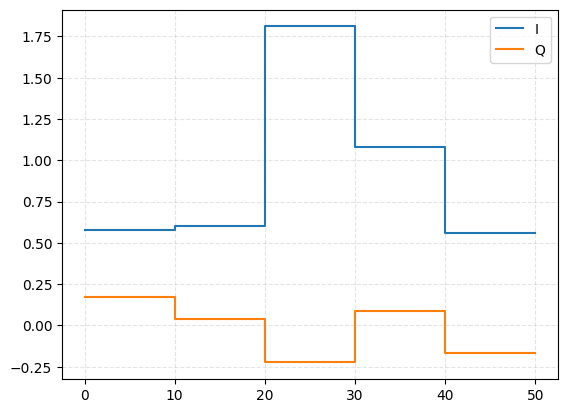

In [7]:
opt_result.plot()

In [8]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

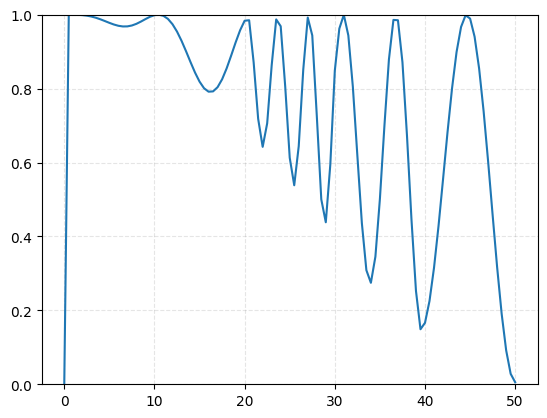

In [9]:
sim_result.plot_unitary_infidelities()

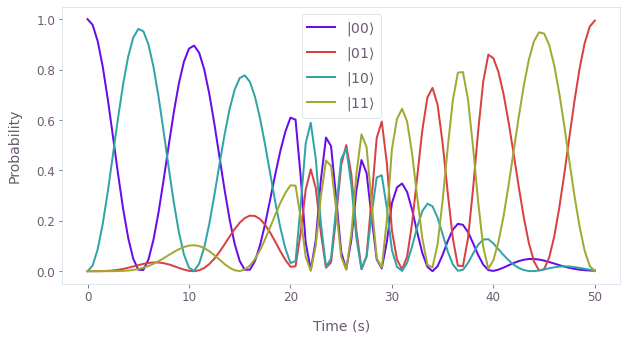

In [10]:
sim_result.plot_populations()

In [11]:
sim_result.display_bloch_sphere(0)

<IPython.core.display.Javascript object>

In [12]:
sim_result.display_bloch_sphere(1)

<IPython.core.display.Javascript object>